In [149]:

import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.cluster import DBSCAN
import os

In [150]:

def procesing(img):
    process = cv2.blur(img, (4, 4))
    process = cv2.Canny(process, 80, 200)
    # plt.imshow(process, "gray")
    process = cv2.dilate(process, np.ones((3, 3), dtype=np.uint8), iterations=2)
    # plt.imshow(process, "gray")
    return process
  

In [151]:
def find_directions(lines, tolerance=np.pi / 6):
    horizontal = []
    vertical = []
    for line in lines:
        rho, theta = line[0]
        if abs(theta) < tolerance or abs(theta - np.pi) < tolerance:
            vertical.append((rho, theta))
        elif abs(theta - np.pi / 2) < tolerance:
            horizontal.append((rho, theta))
    return horizontal, vertical


def print_line(img, all_lines, no_copy = False, print_theta = False):
 
    copy = np.copy(img)
    h, w = img.shape
    extension = max(w, h)*1.1
    if all_lines is not None:
        for line in all_lines:
            rho, theta = line
            if print_theta:
                deg = theta*180/np.pi
                print(f"Degre {deg}")
                print(f"Rho {rho}")
            a = math.cos(theta)
            b = math.sin(theta)
            # Punkt najblizszy srodka ukł. wsp.
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + extension*(-b)), int(y0 + extension*(a)))
            pt2 = (int(x0 - extension*(-b)), int(y0 - extension*(a)))
            cv2.line(copy, pt1, pt2, (255,0 ,0), 3, cv2.LINE_AA) 
        # plt.figure(figsize=(5,5))      
        # plt.imshow(copy, cmap='gray')
        return copy
    
def resize_image(img):

    width = img.shape[1]
    if width > 800:
        scale = 800 / width
        return cv2.resize(img, None, fx=scale, fy=scale)
    else:
        return img

In [152]:
checkboard_bgr = cv2.imread("photo/background_checkboard/checkboard2.jpg")
checkboard_rgb = cv2.cvtColor(checkboard_bgr, cv2.COLOR_BGR2RGB)


gray = cv2.cvtColor(checkboard_bgr, cv2.COLOR_BGR2GRAY)
edges = procesing(gray)

# gray = cv2.equalizeHist(gray)

# equalized = cv2.equalizeHist(checkboard)

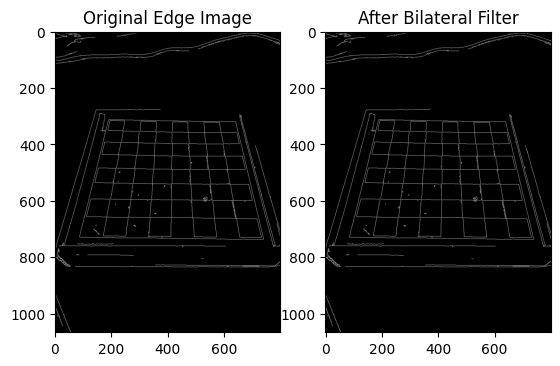

In [153]:
gray = resize_image(gray)
edges = cv2.blur(gray, (4, 4))

edges = cv2.Canny(gray, 80, 200)
plt.subplot(1, 2, 1)
plt.title('Original Edge Image')
plt.imshow(edges, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('After Bilateral Filter')
plt.imshow(edges, cmap='gray')
plt.show()
# plt.imshow(edges, cmap='gray')

(2, 1, 2)


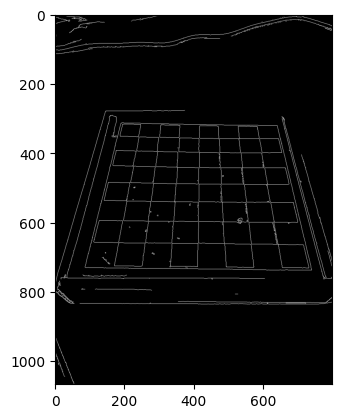

In [154]:
kernel = cv2.getStructuringElement(cv2.MORPH_OPEN,(5,5))# opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernel)
# edges = cv2.dilate(edges, kernel, iterations=1)
plt.imshow(edges, cmap='gray')

lines = cv2.HoughLines(edges, 1, np.pi / 180, 300)
print(lines.shape)
# print_line(checkboard, lines)


In [155]:
horiz, vert = find_directions(lines)
print_line(gray, horiz, print_theta=False)

array([[ 54,  57,  53, ..., 220, 220, 220],
       [ 67,  67,  63, ..., 220, 219, 219],
       [ 63,  64,  66, ..., 221, 219, 219],
       ...,
       [ 24,  24,  24, ..., 168, 169, 169],
       [ 21,  21,  21, ..., 167, 167, 167],
       [ 19,  19,  19, ..., 166, 166, 166]], dtype=uint8)

In [156]:
print(len(horiz))
print(len(vert))

1
1


In [157]:
print_line(gray, horiz)

array([[ 54,  57,  53, ..., 220, 220, 220],
       [ 67,  67,  63, ..., 220, 219, 219],
       [ 63,  64,  66, ..., 221, 219, 219],
       ...,
       [ 24,  24,  24, ..., 168, 169, 169],
       [ 21,  21,  21, ..., 167, 167, 167],
       [ 19,  19,  19, ..., 166, 166, 166]], dtype=uint8)

In [158]:
def normalize_vertical(rho, theta, idx): 
    rho = (-1)*rho
    theta = np.pi - theta
    idx = -1
    return rho, theta, idx

def mean_line(lines):
    """Calculate the mean line (rho, theta) from a list of lines."""
    rhos = []
    thetas = []
    norm_lines = []
    for i in range(len(lines)):
        rho, theta = lines[i]
        if np.pi - np.pi / 8 <= theta <= np.pi:
            rho, theta, i = normalize_vertical(rho, theta, i)
        rhos.append(rho)
        thetas.append(theta)
        norm_lines.append(i)
    return [np.mean(rhos), np.mean(thetas)], norm_lines



In [159]:
m_vert, norm_vert = mean_line(vert)
m_horiz, norm_horiz = mean_line(horiz)
  
# print(m_vert)
# print(m_horiz)
# print_line(checkboard,[m_vert])

In [160]:
def intersection_point(line1, line2):
    """Oblicza punkt przecięcia dwóch linii w formie (rho, theta)."""
    rho1, theta1 = line1
    rho2, theta2 = line2
    
    # Wyliczamy współczynniki (a1, b1) i (a2, b2) z równań linii w przestrzeni biegunowej
    a1, b1 = np.cos(theta1), np.sin(theta1)
    a2, b2 = np.cos(theta2), np.sin(theta2)
    
    # Obliczamy wyznacznik
    d = a1 * b2 - a2 * b1
    if np.isclose(d, 0):
        return None  
    
    x = (rho1 * b2 - rho2 * b1) / d
    y = (rho2 * a1 - rho1 * a2) / d

    return (x, y)



In [161]:
x, y = intersection_point(m_horiz, m_vert)
print(x, y)
# image = cv2.circle(checkboard, (int(x),int(y)), radius=10, color=(0, 0, 255),thickness= -1)
# plt.figure(figsize=(10,10))
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

78.220924 761.0


In [162]:
def cluster_lines(lines1, lines2, eps=40, min_samples=1):
    # Średnia linia pionowa
    mean_vert, norm_lines = mean_line(lines2)

    # Znajdź punkty przecięcia linii poziomych ze średnią pionową linią
    intersections = []
    for h_line in lines1:
        point = intersection_point(h_line, mean_vert)
    
        if point:
            intersections.append(point)
    
    print(f"Number of insertions {len(intersections)}")
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(intersections)
    labels = db.labels_
    # print(len(labels))
    # print(labels[1])


    clustered_lines = []
    for label in set(labels):
        if label == -1:  
            continue

        cluster = []
        for i in range(len(lines1)):
            if labels[i] == label:
                cluster.append(lines1[i])
        mean_cluster, norm_cluster = mean_line(cluster)
        if norm_cluster[0] == -1:
            mean_cluster[0], mean_cluster[1], _ = normalize_vertical(mean_cluster[0], mean_cluster[1], 0)
        clustered_lines.append(mean_cluster)

    return clustered_lines

def lines_distance(lines):
    lines = sorted(lines, key=lambda p: p[1])
    # print
    distances = []
    for i in range(len(lines)):
        rho1, theta1 = lines[i]
        if i != len(lines) - 1:
            rho2, theta2 = lines[i+1]

        # Sprawdzamy, czy linie są równoległe (ta sama theta z małym błędem)
        if abs(theta1 - theta2) < 1e-2:  # Można dostosować próg tolerancji
            distance = abs(rho1 - rho2)
            distances.append(distance)
    return distances
        
    

In [163]:
clust_vert = cluster_lines(vert, horiz)
print(len(clust_vert))
# print_line(gray, clust_vert, print_theta=False)

Number of insertions 1
1


In [164]:
clust_horiz = cluster_lines(horiz, vert)
print(len(clust_horiz))
# print_line(gray, clust_horiz, print_theta=False) 


Number of insertions 1
1


In [165]:

def r_intersetions(checkboard_rgb, horiz, vert):
    im = checkboard_rgb.copy()
    intersections = []
    for h in horiz:
        for v in vert:
            x, y = intersection_point(h, v)
            intersections.append((x, y))
            image = cv2.circle(im, (int(x),int(y)), radius=10, color=(0, 255, 0),thickness= -1)
            # plt.imshow(image)
    print(f"Number of find insertions: {len(intersections)}")
    return intersections, image

intersections, _ = r_intersetions(checkboard_rgb, clust_vert, clust_horiz)

Number of find insertions: 1


In [166]:
print(intersections)

[(np.float32(78.220924), np.float32(761.0))]


In [167]:

def find_corners(intersections1, image):
    left_top = min(intersections1, key=lambda p: p[0] + p[1])  # Najmniejsza suma x + y
    right_top = max(intersections1, key=lambda p: p[0] - p[1])  # Największa różnica x - y
    right_bottom = max(intersections1, key=lambda p: p[0] + p[1])  # Największa suma x + y
    left_bottom = min(intersections1, key=lambda p: p[0] - p[1])  # Najmniejsza różnica x - y
    
    corners = [left_top, right_top, right_bottom, left_bottom]
    
    im = image.copy()
    for x, y in corners:
            cv2.circle(im, (int(x),int(y)), radius=10, color=(255, 0, 0),thickness= -1)
    
    
    # plt.imshow(im)
    return corners
# corners = find_corners(intersections, checkboard_rgb)



In [168]:
def project2perspective(inter, homography):
    intersections_homogeneous = np.hstack((inter, np.ones((len(inter), 1))))
    projected = (homography @ intersections_homogeneous.T).T
    # print(projected)
    
    projected /= projected[:, 2].reshape(-1, 1)  
    return projected[:, :2]


def find_warped(inter, img, corners, disp = False):
    image = img.copy()
    pattern_size=(8,8)
    square_size = 100  
    dstPoints = np.array([
        [0, 0],
        [square_size * pattern_size[0], 0],
        [square_size * pattern_size[0], square_size * pattern_size[1]],
        [0, square_size * pattern_size[1]]
    ], dtype='float32')
    
    srcPoints = np.array([
        corners[0],  
        corners[1], 
        corners[2], 
        corners[3]  
    ], dtype='float32')
    
    H, status = cv2.findHomography(srcPoints, dstPoints)
    output_size = (square_size * pattern_size[0], square_size * pattern_size[1])
    # output_size = (int(right_bottom[1] - right_top[1]),int(right_top[0] - left_top[0]  ) )
    
    print(f"Output size {output_size}")
    projected_points = project2perspective(inter, H)
    print(f"Projected points {projected_points.shape}")
    
    warped_image = cv2.warpPerspective(image, H, output_size)
    if disp:
        plt.imshow(warped_image, "gray")
        plt.scatter(projected_points[:, 0], projected_points[:, 1], color='red', marker='x')
    plt.show()
    return projected_points, warped_image, H

def display_intersection(intersectionsn, img):
    im = img.copy()
    for x, y in intersectionsn:
        cv2.circle(im, (int(x),int(y)), radius=10, color=(255, 0, 0),thickness= -1)
    return im    

        

    
    
# projected_points, warped_image = find_warped(intersections, gray, corners, True)

In [169]:
def expand_contour(contour, scale=1.1):

    M = cv2.moments(contour)
    if M["m00"] == 0:  
        cx, cy = 0, 0
    else:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    centroid = np.array([cx, cy])
    

    expanded_contour = []
    for point in contour[:, 0, :]: 
        vector = point - centroid
        expanded_point = centroid + vector * scale
        expanded_contour.append(expanded_point)
    
    return np.array(expanded_contour, dtype=np.int32).reshape(-1, 1, 2)  
def correct_insertion(contur, intersections):
    correct_intersections = []

    if isinstance(contur, list):
        contur = np.array(contur, dtype=np.int32)
    
    contur = expand_contour(contur, scale=1.3)
  
    for point in intersections:
        dist = cv2.pointPolygonTest(contur, tuple(point), False)
        if dist >= 0:
            correct_intersections.append(point)
    return correct_intersections, contur
       
# checkboard_bgr = cv2.imread("photo/background_checkboard/checkboard1.jpg")
# checkboard_rgb = cv2.cvtColor(checkboard_bgr, cv2.COLOR_BGR2RGB)
# # checkboard_localization(checkboard_rgb)
# img = checkboard_rgb
def checkboard_localization(image):
    copy = image.copy()
    
    gray = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    
    edges = procesing(gray)
    
    # Przygotowanie układu do wyświetlania obrazów
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 6 wierszy, 1 kolumna
    axes = axes.ravel()
    axes[0].imshow(edges, cmap="gray")
    axes[0].set_title("Edges")
    # axes[0].axis("off")
    
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 300)
    horiz, vert = find_directions(lines)
    print(f"Horiz: {len(horiz)} \n Vert: {len(vert)}")
    im = print_line(gray, horiz, print_theta=False)
    im = print_line(gray, vert, print_theta=False)

    clust_horiz = cluster_lines(horiz, vert)
    distances = lines_distance(clust_horiz)
    print("Odległości między równoległymi liniami:", distances)
    clust_vert = cluster_lines(vert, horiz)
    
    cluster = np.concatenate((clust_vert, clust_horiz), axis=0)
    
    black_image = np.zeros((h, w), dtype=np.uint8)
    # print(f"Clust: {cluster.shape}")
    # print(cluster)
    print(f"Cluster Horiz: {len(clust_horiz)} \n Cluster Vert: {len(clust_vert)}")
    
    clust_im = print_line(black_image, cluster, print_theta=False)
    axes[1].imshow(clust_im, cmap="gray")
    axes[1].set_title("Find lines ideal")
    # axes[1].axis("off")
    
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    board_contour = max(contours, key=cv2.contourArea)
    print(len(board_contour))
    # Wyznaczenie prostokąta ograniczającego
    x, y, w, h = cv2.boundingRect(board_contour)
    corners_b = [[x, y], [x + w, y], [x, y + h], [x + w, y + h]]
    
    # f_cluster = lines_within_contour(cluster, corners_b)
    print(corners_b)
    
    top_left = corners_b[0]         # Lewy górny
    bottom_right = corners_b[3]     # Prawy dolny
    
    # Rysowanie prostokąta na obrazie
    cv2.rectangle(gray, top_left, bottom_right, (0, 255, 0), 6)
    
    im = print_line(gray, cluster, print_theta=False)
    axes[2].imshow(im, cmap="gray")
    axes[2].set_title("Clustered  Lines with contur")
    # axes[2].axis("off")

    intersections, img_inter = r_intersetions(copy, clust_horiz, clust_vert)
    
    filtred_intersections, cnt = correct_insertion(board_contour, intersections)
    
    x, y, w, h = cv2.boundingRect(cnt)
    corners_b = [[x, y], [x + w, y], [x, y + h], [x + w, y + h]]
    top_left = corners_b[0]         # Lewy górny
    bottom_right = corners_b[3]     # Prawy dolny
    
    # Rysowanie prostokąta na obrazie
    cv2.rectangle(gray, top_left, bottom_right, (0, 255, 0), 6)
    
    
    img_inter1 = display_intersection(filtred_intersections, copy)
    cv2.rectangle(img_inter1, top_left, bottom_right, (0, 255, 0), 6)
    
    axes[3].imshow(img_inter1, cmap="gray")   
    axes[3].set_title("Intersections filtred")
    
    # intersections = correct_insertion(corners_b, intersections)
    # axes[3].axis("off") 
    corners = find_corners(filtred_intersections, copy)
    print("t")
    points, warped_image, H = find_warped(filtred_intersections, copy, corners)
    # axes[4].imshow(warped_image)
    # axes[4].set_title("Warped image")

    # 
    plt.tight_layout()
    plt.show()
    # axes[5].axis("off")
    plt.figure(figsize=(4, 4))
    plt.imshow(warped_image, cmap="gray")
    plt.scatter(points[:, 0], points[:, 1], color='red', marker='x')
    plt.title("Warped Image (Manual)")
    # plt.axis("off")
    plt.show()
    return H, cluster, filtred_intersections
    # print(f"Projected points {points}")
    


In [170]:
# dir_path = "photo/background_checkboard"
# photo_paths = os.walk(dir_path)
# for (root, dirs, file) in photo_paths:
#     for f in file:
#         path = os.path.join(str(root), str(f))
#         print(path)
#         checkboard_bgr = cv2.imread(path)
#         checkboard_rgb = cv2.cvtColor(checkboard_bgr, cv2.COLOR_BGR2RGB)
#         checkboard_localization(checkboard_rgb)

In [171]:
def hist_cdf(img, title):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    plt.subplot(2, 1, 1)
    plt.plot(cdf_normalized, color = 'b')
    plt.hist(img.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.title(f"{title}")
    plt.show()

Horiz: 48 
 Vert: 64
Number of insertions 48
Odległości między równoległymi liniami: [np.float32(80.33331), np.float32(93.5), np.float32(104.2381), np.float32(112.17859), np.float32(0.0)]
Number of insertions 64
Cluster Horiz: 10 
 Cluster Vert: 9
1057
[[163, 376], [1151, 376], [163, 1202], [1151, 1202]]
Number of find insertions: 90
t
Output size (800, 800)
Projected points (77, 2)


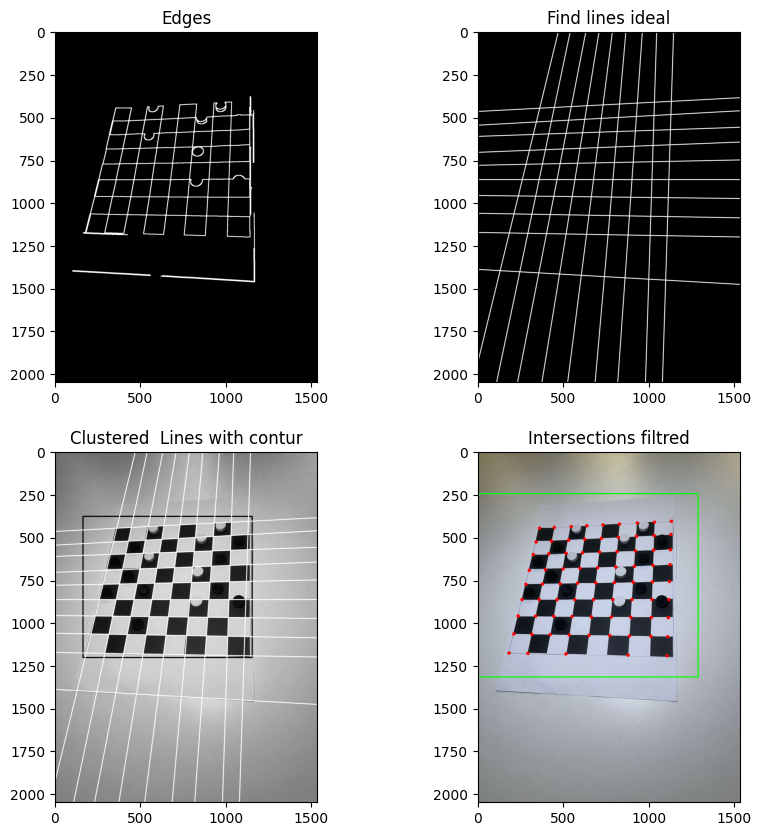

<Figure size 640x480 with 0 Axes>

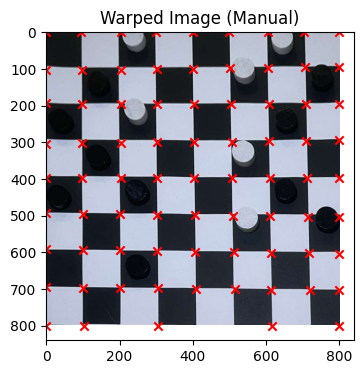

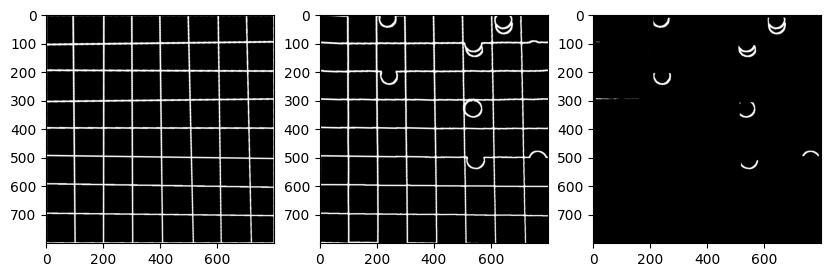

In [172]:
path = "photo/background_checkboard/ref.jpg"

checkboard_bgr = cv2.imread(path)
checkboard_rgb = cv2.cvtColor(checkboard_bgr, cv2.COLOR_BGR2RGB)
img = checkboard_rgb.copy()

H, lines, intersections  = checkboard_localization(img)
edges = procesing(img)

h, w = edges.shape
black = np.zeros((h,w), dtype=np.uint8)
lines_img = print_line(black, lines)

_, lines_binary = cv2.threshold(lines_img, 127, 255, cv2.THRESH_BINARY)
_, edges_binary = cv2.threshold(edges, 127, 255, cv2.THRESH_BINARY)

 
# Odejmowanie binarne: usunięcie linii
result = cv2.bitwise_and(edges_binary, cv2.bitwise_not(lines_binary))

edges = cv2.warpPerspective(edges_binary, H, (800, 800))
lines_img = cv2.warpPerspective(lines_binary, H, (800, 800))

horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 1)) 
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 12))  
horizontal_dilated = cv2.dilate(lines_img, horizontal_kernel, iterations=1)
vertical_dilated = cv2.dilate(lines_img, vertical_kernel, iterations=1)
combined_dilated = cv2.bitwise_or(horizontal_dilated, vertical_dilated)
result = cv2.subtract(edges, combined_dilated )

# result = cv2.normalize(result, None, 200, 255, cv2.NORM_MINMAX)

# project2perspective(result, H)
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(lines_img, cmap="gray")

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap="gray")

plt.subplot(1, 3, 3)
plt.imshow(result, cmap="gray")

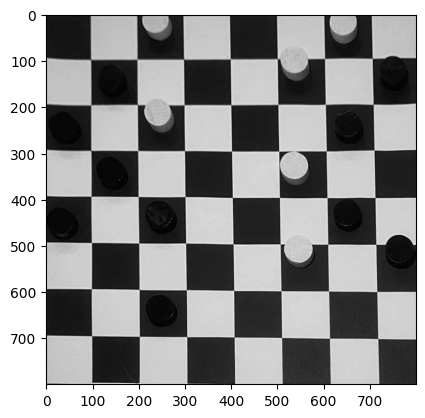

In [173]:
board = cv2.warpPerspective(checkboard_rgb, H, (800, 800))
gray = cv2.cvtColor(board, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap="gray")


In [174]:
# H, lines, intersections = checkboard_localization(img)

def remove_background(image, H, lines ):
    img = image.copy()
    # edges = procesing(img)
    
    h, w, _ = img.shape
    black = np.zeros((h, w), dtype=np.uint8)
    lines_img = print_line(black, lines)
     
    _, lines_binary = cv2.threshold(lines_img, 127, 255, cv2.THRESH_BINARY)
    # _, edges_binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    board = cv2.warpPerspective(img, H, (800, 800))
    lines_img = cv2.warpPerspective(lines_binary, H, (800, 800))
    
    gray = cv2.cvtColor(board, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8)) # limit = 2
    enhanced_img = clahe.apply(gray)
    blur = cv2.blur(enhanced_img, (3, 3))
    edges = cv2.Canny(blur, 70, 200)
    
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 12))
    horizontal_dilated = cv2.dilate(lines_img, horizontal_kernel, iterations=1)
    vertical_dilated = cv2.dilate(lines_img, vertical_kernel, iterations=1)
    combined_dilated = cv2.bitwise_or(horizontal_dilated, vertical_dilated)
    result = cv2.subtract(edges, combined_dilated)
    
    # result = cv2.normalize(result, None, 200, 255, cv2.NORM_MINMAX)
    # project2perspective(result, H)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(lines_img, cmap="gray")
    plt.title("Board Lines Ideal")
    
    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Board Edges")
    
    plt.subplot(1, 3, 3)
    plt.imshow(result, cmap="gray")
    plt.title("Removed Background")
    return result

def find_pawn(image):
    img = image.copy()
    h, w= img.shape
    h = h/8
    rmin = (h/2 - h*0.25)
    rmax = (h/2 + h*0.05)
    print(f"Min radius{rmin} Max radius{rmax}")
    # dilation = cv2.cvtColor(dilation, cv2.COLOR_BGR2GRAY)
    
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                               param1=50, param2=20, minRadius=int(rmin),
                               maxRadius=int(rmax))
    print(f"Count of found pawn {len(circles)}") 

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(img, (x, y), r, (255, 255, 255), int(0.1*h))
    
    plt.imshow(img, "gray")
    plt.title("Circles")
    return circles
    

In [175]:

# dir_path = "photo/background_checkboard"
# photo_paths = os.walk(dir_path)
# for (root, dirs, file) in photo_paths:
#     for f in file:
#         path = os.path.join(str(root), str(f))
#         print(path)
#         checkboard_bgr = cv2.imread(path)
#         checkboard_rgb = cv2.cvtColor(checkboard_bgr, cv2.COLOR_BGR2RGB)
#         H, lines, intersections = checkboard_localization(checkboard_rgb)
#         board = remove_background(checkboard_rgb, H, lines)
#         circles = find_pawn(board)


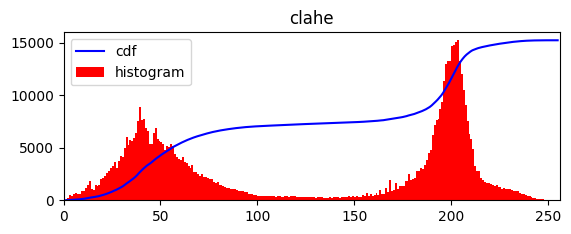

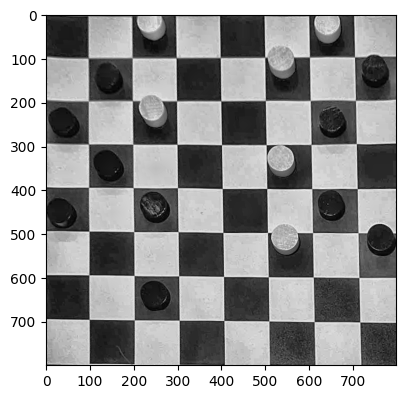

In [176]:
clahe = cv2.createCLAHE(clipLimit=4.5, tileGridSize=(8, 8))
enhanced_img = clahe.apply(gray)
plt.subplot(2,1,1)
hist_cdf(enhanced_img, "clahe")
plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
plt.imshow(enhanced_img, cmap="gray")



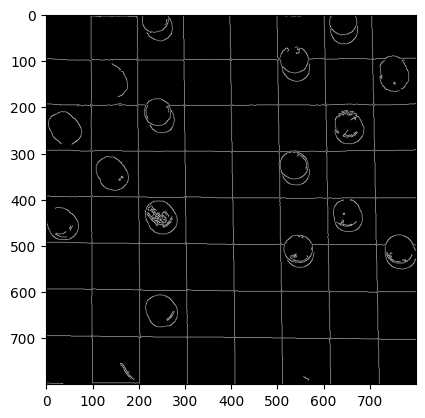

In [177]:
blur = cv2.blur(enhanced_img, (3, 3))
edges = cv2.Canny(blur, 70, 200)
plt.imshow(edges, cmap="gray")

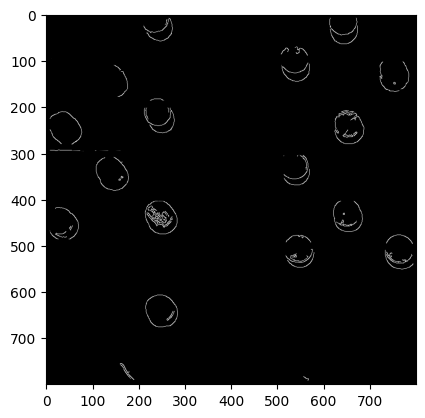

In [178]:

horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 1)) 
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 10))  
horizontal_dilated = cv2.dilate(lines_img, horizontal_kernel, iterations=1)
vertical_dilated = cv2.dilate(lines_img, vertical_kernel, iterations=1)
combined_dilated = cv2.bitwise_or(horizontal_dilated, vertical_dilated)
result = cv2.subtract(edges, combined_dilated )


plt.imshow(result, cmap="gray")



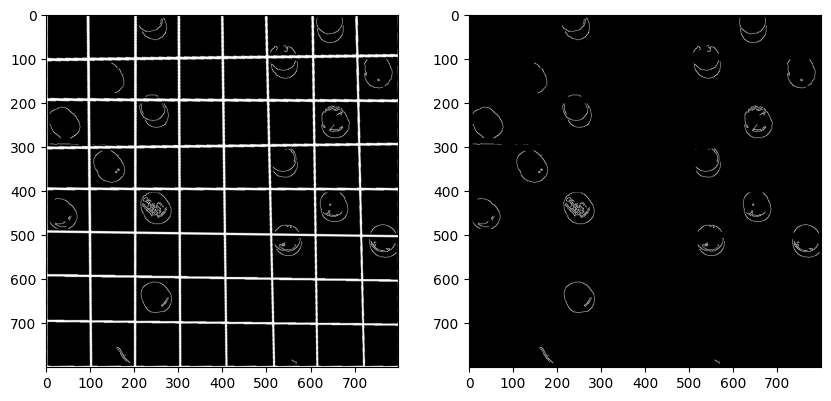

In [179]:
add = cv2.add(result, lines_img)
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(add, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(result, cmap="gray")


Min radius25.0 Max radius55.0
Count of found pawn 16


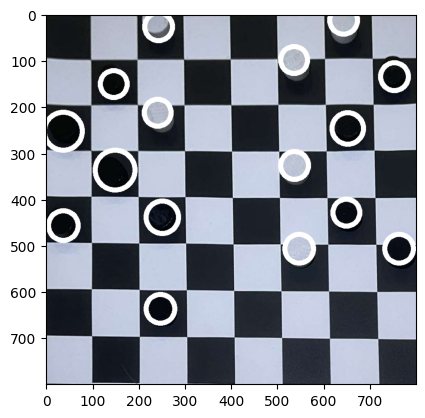

In [180]:
def display_board(board):
    """Wyświetla planszę w konsoli."""
    for row in board:
        print(' '.join(row))

h, w = result.shape
h = h/8
rmin = (h/2 - h*0.25)
rmax = (h/2 + h*0.05)

board_size = 8
square_size = 100
print(f"Min radius{rmin} Max radius{rmax}")
# dilation = cv2.cvtColor(dilation, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(result, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                           param1=50, param2=10, minRadius=int(rmin),
                           maxRadius=int(rmax))
boardd = [['.' for _ in range(board_size)] for _ in range(board_size)]


im = board.copy()
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(im, (x, y), r, (255, 255, 255), int(0.1*h))
        col = x // square_size
        row = y // square_size

        if gray[y, x] < 128:  
            boardd[row][col] = 'B'
        else:                 
            boardd[row][col] = 'W'

plt.imshow(im, "gray")
print(f"Count of found pawn {len(circles)}")

In [181]:
display_board(boardd)


. . W . . W W .
. B . . . . . B
B . W . . . B .
. B . . . W . .
B . B . . . B .
. . . . . W . B
. . B . . . . .
. . . . . . . .


# RANSAC

In [334]:
def choose_lines(lines):
    line1 = random.choice(lines)
    line2 = random.choice(lines)
    while line1 == line2:
        line2 = random.choice(lines)
    return line1, line2

def count_inliers(H, intersections, tolerance=0.5):

    intersections_homogeneous = np.hstack((intersections, np.ones((len(intersections), 1))))
    projected = (H @ intersections_homogeneous.T).T
    # print(projected)

    projected /= projected[:, 2].reshape(-1, 1)  # Konwersja do współrzędnych niejednorodnych
    # print("************************")
    # print(projected)
    rounded = np.round(projected[:, :2])
    distances = np.linalg.norm(projected[:, :2] - rounded, axis=1)
    inlier_mask = distances < tolerance
    return np.sum(inlier_mask), projected
def ransac(img, horiz, vert, intersections, tolerance=0.1, best_H = None,
best_inliers = 0):
    # 1 step
    horiz1, horiz2 = choose_lines(horiz)
    vert1, vert2 = choose_lines(vert)
    
    p1 = intersection_point(horiz1, vert1)
    p2 = intersection_point(horiz2, vert1)
    p3 = intersection_point(horiz1, vert2)
    p4 = intersection_point(horiz2, vert2)

    # 2
    for sx in range(1,9):
        for sy in range(1,9):
            srcPoints = np.array([p1, p2, p3, p4])
            dstPoints = np.array([
            [0, 0],  # Lewy górny
            [sx, 0],  # Prawy górny
            [0, sy],  # Lewy dolny
            [sx, sy],  # Prawy dolny
            ], dtype=np.float32)
            
            H, status = cv2.findHomography(srcPoints, dstPoints)
            # dst = cv2.warpPerspective(img, H, (50, 50))
            # plt.imshow(dst)
            # 3
            inliers, _ = count_inliers(H, intersections, tolerance)
            
            if inliers > best_inliers:
                best_inliers = inliers
                best_H = H
            # print(inliers)

    return best_H, best_inliers

# ransac(checkboard_rgb, clust_horiz, clust_vert, 3, 2, intersections, tolerance=0.5)
H, inliers = ransac(checkboard_rgb, clust_horiz, clust_vert, intersections, best_H = None,
best_inliers = 0 )
best_H = None
best_inliers = 0
# while best_inliers > len(intersections)*0.5:
for i in range(1):
            H, inliers = ransac(checkboard_rgb, clust_horiz, clust_vert, intersections, best_H = None,
best_inliers = 0 )
            if inliers > best_inliers:
                best_H = H
                best_inliers = inliers
                # b_sx = sx
                # b_sy = sy
dst = cv2.warpPerspective(image, H*100, (50, 50))
plt.imshow(dst)
print(inliers)

NameError: name 'image' is not defined

In [328]:

# best_H = None
# best_inliers = 0
# while best_inliers < len(intersections)*0.5:
#     for sx in range(1, 9):
#         for sy in range(1, 9):
#             H, inliers, inlier_mask = ransac(checkboard_rgb, clust_horiz, clust_vert, sx, sy, intersections )
#             if inliers > best_inliers:
#                 best_H = H
#                 best_inliers = inliers
#                 best_inliers_mask = np.int_(inlier_mask)
#                 b_sx = sx
#                 b_sy = sy
#                 
# print(best_inliers)
# print(best_H)
# print(b_sx)
# print(b_sy)
# print(best_inliers_mask)

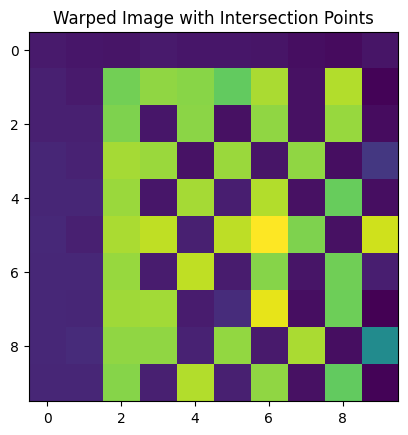

In [329]:
warped_img = cv2.warpPerspective(gray, best_H, (10, 10))

plt.imshow(warped_img)
# plt.scatter(best_inliers_mask[:, 0], best_inliers_mask[:, 1], color='red')  
plt.title("Warped Image with Intersection Points")
plt.show()